In [6]:
import importlib
import time
import os
import pickle
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy import integrate
from scipy import interpolate

In [7]:
from multi_loc import covariance, assimilate, utilities

In [8]:
%matplotlib inline

In [9]:
def imshow(X, title=None, vmin=None, vmax=None, cmap=None):
    plt.figure()
    im = plt.imshow(X, vmin=vmin, vmax=vmax, cmap=cmap)
    plt.colorbar(im)
    plt.title(title)

In [11]:
os.path.join('one', 'two', 'three')

'one/two/three'

In [50]:
tune_name = 'fine_obs'

save_dir = 'RK_tune'

stdrd_dir = 'stdrd_loc'

smooth_dir = 'smooth_loc'

home = os.path.expanduser("~")

save_dir = os.path.join(
    home,
    'Documents/python_code/multi_loc/notebooks/',
    save_dir)
    
this_path = os.path.join(save_dir, 'Z_GT.npy')
Zgt = np.load(this_path)

this_path = os.path.join(save_dir, 'Z0_ens.npy')
Z0ens = np.load(this_path)

this_path = os.path.join(save_dir, 't_gt.npy')
t_gt = np.load(this_path)

this_path = os.path.join(save_dir, 't_lr.npy')
t_lr = np.load(this_path)

this_path = os.path.join(save_dir, 'run_vars.pkl')
with open(this_path, mode='rb') as f:
    run_vars = pickle.load(f)

In [15]:
for key, value in run_vars.items():
    print(key + ' = ' + str(value))
    exec(key + '=value')

Nz = 960
K = 32
I = 12
F = 15.0
b = 10.0
c = 2.5
alpha = 0.12414383561643835
beta = 0.013746194824961947
coarse = 8
Nez = 20
Nex = 500
dt_rk = 0.004166666666666667
dt_lr = 0.1
dt_gt = 0.0020833333333333333
Tic = 24.0
Tlr = 4000
Tgt = 250


In [16]:
tune_dir = os.path.join(save_dir, tune_name)
# if not os.path.exists(tune_dir):
#     os.mkdir(tune_dir)

# dt_trial_rk = 0.05/24
# dt_kf = 0.05
# dt_save = None
# Tkf = Tgt/5     #### Change this
# Tspin_index = 500
# Tspin = dt_kf * Tspin_index

# alpha_range = np.array([0, 0.01, 0.02, 0.04, 0.08], dtype='float')
# loc_range = np.array([5, 10, 15, 20, 30, 40, 50, 60], dtype='float')


# R_sd = 2
# everyH = 24
# Hz = np.eye(Nz)[::everyH]
# Ny = Hz.shape[0]
# Rz = np.eye(Ny) * R_sd**2

# fine_obs_dict = {'dt_trial_rk': dt_trial_rk,
#                  'dt_kf': dt_kf,
#                  'dt_save': dt_save,
#                  'Tkf': Tkf,
#                  'Tspin': Tspin,
#                  'alpha_range': alpha_range,
#                  'loc_range': loc_range,
#                  'R_sd': R_sd,
#                  'Hz': Hz,
#                  'Rz': Rz}

this_path = os.path.join(tune_dir, 'fine_obs_dict.pkl')
with open(this_path, mode='rb') as f:
    fine_obs_dict = pickle.load(f)

for key, value in fine_obs_dict.items():
    print(key + ' = ' + str(value))
    exec(key + '=value')
    
Ny = Hz.shape[0]
Rz = np.eye(Ny)

dt_trial_rk = 0.0020833333333333333
dt_kf = 0.05
dt_save = None
Tkf = 50.0
Tspin = 25.0
alpha_range = [0.   0.01 0.02 0.04 0.08]
loc_range = [ 5. 10. 15. 20. 30. 40. 50. 60.]
R_sd = 2
everyH = 24
Hz = [[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Rz = [[4. 0. 0. ... 0. 0. 0.]
 [0. 4. 0. ... 0. 0. 0.]
 [0. 0. 4. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 4. 0. 0.]
 [0. 0. 0. ... 0. 4. 0.]
 [0. 0. 0. ... 0. 0. 4.]]


In [17]:
Nobs = int(Tkf/dt_kf) + 1
t_kf = np.linspace(0, Tkf, Nobs)

Ngt = int(Tgt/dt_gt) + 1
t_gt = np.linspace(0, Tgt, Ngt)
index_Tkf = int(Tkf/dt_gt) + 1

every_t = int(dt_kf/dt_gt)

if not np.allclose(t_kf, t_gt[0:index_Tkf:every_t]):
    print('They do not match')

In [18]:
Zloc = np.arange(Nz)

Zgt_ts = xr.DataArray(Zgt[:, 0:index_Tkf:every_t],
                      dims=('loc', 'time'),
                      coords={'loc': Zloc,
                              'time': t_kf})
Zobs_ts = Zgt[::everyH, 0:index_Tkf:every_t]
Zobs_ts = xr.DataArray(Zobs_ts,
                       dims=('loc', 'time'),
                       coords={'loc': Zloc[::everyH],
                               'time': t_kf})
del Zgt

In [53]:
importlib.reload(assimilate)
importlib.reload(utilities)

mu_f = []
mu_a = []

std_f = []
std_a = []

rmse_array_f = np.ones([alpha_range.size, loc_range.size]) * np.nan
std_array_f = rmse_array_f.copy()

rmse_array_a = rmse_array_f.copy()
std_array_a = rmse_array_f.copy()

stdrd_dir = os.path.join(tune_dir, stdrd_dir)
smooth_dir = os.path.join(tune_dir, smooth_dir)

for alpha_count, this_alpha in enumerate(alpha_range):
    for loc_count, this_loc in enumerate(loc_range):
        this_folder_name = f'inf_{alpha_count:04}_loc_{loc_count:04}'
        this_dir_name = os.path.join(stdrd_dir, this_folder_name)
#         if not os.path.exists(this_dir_name):
#             os.mkdir(this_dir_name)
        print('alpha: ', this_alpha, '; loc: ', this_loc)
        print('alpha_count: ', alpha_count, ': loc_count: ', loc_count)

#         rho_Zc = np.arange(Nz)
#         rho_Zc = np.minimum(np.abs(Nz - rho_Zc)%Nz, rho_Zc)
#         rho_Zc = np.exp(-(rho_Zc**2)/(2*this_loc**2))
#         rho_Zc = sp.linalg.circulant(rho_Zc)
        
#         this_path = os.path.join(this_dir_name, 'rho0z')
#         np.save(this_path, this_loc)
        
#         this_path = os.path.join(this_dir_name, 'alpha')
#         np.save(this_path, this_alpha)

#         cycle_dict = {'Z0ens': Z0ens,
#                       'Zobs_ts': Zobs_ts,
#                       'Rz': Rz, 'Hz': Hz,
#                       'Tkf': Tkf,
#                       'dt_kf': dt_kf,
#                       'dt_rk': dt_trial_rk,
#                       'rho_Z': rho_Zc,
#                       'rho0_Z': this_loc,
#                       'alpha': this_alpha}
        try:
            this_path = os.path.join(this_dir_name, 'mu_f.nc')
            print(this_path)
            mu_f.append(xr.open_dataarray(this_path))
            
            this_path = os.path.join(this_dir_name, 'mu_a.nc')
            print(this_path)
            mu_a.append(xr.open_dataarray(this_path))
            
#             this_path = os.path.join(this_dir_name, 'std_f.nc')
#             std_f.to_netcdf(this_path)

#             this_path = os.path.join(this_dir_name, 'mu_a.nc')
#             mu_a.to_netcdf(this_path)

#             this_path = os.path.join(this_dir_name, 'std_a.nc')
#             std_a.to_netcdf(this_path)


#             rmse_array_f[alpha_count, loc_count] = (np.sqrt(
#                 ((mu_f - Zgt_ts.sel(time=mu_f.time))**2).mean(axis=0))
#                                           .isel(time=slice(Tspin_index, None)).mean())
#             rmse_array_a[alpha_count, loc_count] = (np.sqrt(
#                 ((mu_a - Zgt_ts.sel(time=mu_f.time))**2).mean(axis=0))
#                                           .isel(time=slice(Tspin_index, None)).mean())
#             std_array_f[alpha_count, loc_count] = (np.sqrt((std_f**2).mean(axis=0))
#                                                   .isel(time=slice(Tspin_index, None)).mean())
#             std_array_a[alpha_count, loc_count] = (np.sqrt((std_a**2).mean(axis=0))
#                                                   .isel(time=slice(Tspin_index, None)).mean())
        except:
            print(this_dir_name, ' has failed.')
        

alpha:  0.0 ; loc:  5.0
alpha_count:  0 : loc_count:  0
/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/fine_obs/stdrd_loc/inf_0000_loc_0000/mu_f.nc
/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/fine_obs/stdrd_loc/inf_0000_loc_0000/mu_a.nc
alpha:  0.0 ; loc:  10.0
alpha_count:  0 : loc_count:  1
/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/fine_obs/stdrd_loc/inf_0000_loc_0001/mu_f.nc
/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/fine_obs/stdrd_loc/inf_0000_loc_0001/mu_a.nc
alpha:  0.0 ; loc:  15.0
alpha_count:  0 : loc_count:  2
/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/fine_obs/stdrd_loc/inf_0000_loc_0002/mu_f.nc
/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/fine_obs/stdrd_loc/inf_0000_loc_0002/mu_a.nc
alpha:  0.0 ; loc:  20.0
alpha_count:  0 : loc_count:  3
/Users/harty/Documents/python_code/multi_loc/notebooks/RK_tune/fine_obs/stdrd_loc/inf_0000_loc_0003/mu_f.nc
/Users/harty/Docu

In [56]:
importlib.reload(assimilate)
importlib.reload(utilities)


rmse_array_f = np.ones([smooth_range.size,
                        fine_loc_range.size,
                        coarse_loc_range.size]) * np.nan
std_array_f = rmse_array_f.copy()

rmse_array_a = rmse_array_f.copy()
std_array_a = rmse_array_f.copy()

smooth_dir = os.path.join(tune_dir, 'smooth_loc')
if not os.path.exists(smooth_dir):
    os.mkdir(smooth_dir)

for smooth_count, this_smooth in enumerate(smooth_range):
    for fine_loc_count, this_fine_loc in enumerate(fine_loc_range):
        for coarse_loc_count, this_coarse_loc in enumerate(coarse_loc_range):
            this_folder_name = f'inf_{alpha_count:04}_smooth_{smooth_count:04}'
            this_folder_name += f'_floc_{fine_loc_count:04}_cloc_{coarse_loc_count:04}'
            this_dir_name = os.path.join(smooth_dir, this_folder_name)
#             if not os.path.exists(this_dir_name):
#                 os.mkdir(this_dir_name)
            print('alpha: ', this_alpha, '; smooth: ', this_smooth)
            print('fine_loc: ', this_fine_loc, '; coarse_loc: ', this_coarse_loc)
            print(this_dir_name)
            
#             rho_Zf = np.arange(Nz)
#             rho_Zf = np.minimum(np.abs(Nz - rho_Zf)%Nz, rho_Zf)
#             rho_Zf = np.exp(-(rho_Zf**2)/(2*this_fine_loc**2))
#             rho_Zf = sp.linalg.circulant(rho_Zf)

#             rho_Zc = np.arange(Nz)
#             rho_Zc = np.minimum(np.abs(Nz - rho_Zc)%Nz, rho_Zc)
#             rho_Zc = np.exp(-(rho_Zc**2)/(2*this_coarse_loc**2))
#             rho_Zc = sp.linalg.circulant(rho_Zc)

#             this_path = os.path.join(this_dir_name, 'rho0f')
#             np.save(this_path, this_fine_loc)
            
#             this_path = os.path.join(this_dir_name, 'rho0c')
#             np.save(this_path, this_coarse_loc)

#             this_path = os.path.join(this_dir_name, 'alpha')
#             np.save(this_path, this_alpha)
            
#             this_path = os.path.join(this_dir_name, 'smooth')
#             np.save(this_path, this_smooth)
            
#             this_path = os.path.join(this_dir_name, 'N_laml')
#             np.save(this_path, N_laml)

#             cycle_dict = {'Z0ens': Z0ens,
#                           'Zobs_ts': Zobs_ts,
#                           'Rz': Rz, 'Hz': Hz,
#                           'Tkf': Tkf,
#                           'dt_kf': dt_kf,
#                           'dt_rk': dt_trial_rk,
#                           'rho_Zc': rho_Zc,
#                           'rho_Zf': rho_Zf,
#                           'N_laml': N_laml,
#                           'smooth_len': this_smooth,
#                           'alpha': this_alpha}
#             returned_dict = assimilate.cycle_KF_LM3_smooth(**cycle_dict)
#             mu_f = returned_dict['mu_f']
#             std_f = returned_dict['std_f']

#             mu_a = returned_dict['mu_a']
#             std_a = returned_dict['std_a']

            this_path = os.path.join(this_dir_name, 'mu_f.nc')
            mu_f = xr.open_dataarray(this_path)

#             this_path = os.path.join(this_dir_name, 'std_f.nc')
#             std_f.to_netcdf(this_path)

#             this_path = os.path.join(this_dir_name, 'mu_a.nc')
#             mu_a.to_netcdf(this_path)

#             this_path = os.path.join(this_dir_name, 'std_a.nc')
#             std_a.to_netcdf(this_path)


            rmse_array_f[smooth_count, fine_loc_count, coarse_loc_count] = (np.sqrt(
                ((mu_f - Zgt_ts.sel(time=mu_f.time))**2).mean(axis=0))
                                          .isel(time=slice(Tspin_index, None)).mean())
#             rmse_array_a[smooth_count, fine_loc_count, coarse_loc_count] = (np.sqrt(
#                 ((mu_a - Zgt_ts.sel(time=mu_f.time))**2).mean(axis=0))
#                                           .isel(time=slice(Tspin_index, None)).mean())
#             std_array_f[smooth_count, fine_loc_count, coarse_loc_count] = (np.sqrt((std_f**2).mean(axis=0))
#                                                   .isel(time=slice(Tspin_index, None)).mean())
#             std_array_a[smooth_count, fine_loc_count, coarse_loc_count] = (np.sqrt((std_a**2).mean(axis=0))
#                                                   .isel(time=slice(Tspin_index, None)).mean())
            print('rmse_f: ', rmse_array_f[smooth_count, fine_loc_count, coarse_loc_count])
#             print('rmse_a: ', rmse_array_a[smooth_count, fine_loc_count, coarse_loc_count])

NameError: name 'smooth_range' is not defined

In [ ]:
smooth_di

In [54]:
this_path = os.path.join(stdrd_dir, 'rmse_array_f.npy')
rmse_array_f_stdrd = np.load(this_path)

this_path = os.path.join(stdrd_dir, 'std_array_f.npy')
std_array_f_stdrd = np.load(this_path)

this_path = os.path.join(stdrd_dir, 'rmse_array_a.npy')
rmse_array_a_stdrd = np.load(this_path)

this_path = os.path.join(stdrd_dir, 'std_array_a.npy')
std_array_a_stdrd = np.load(this_path)



this_path = os.path.join(smooth_dir, 'rmse_array_f.npy')
rmse_array_f_smooth = np.load(this_path)

this_path = os.path.join(smooth_dir, 'std_array_f.npy')
std_array_f_smooth = np.load(this_path)

this_path = os.path.join(smooth_dir, 'rmse_array_a.npy')
rmse_array_a_smooth = np.load(this_path)

this_path = os.path.join(smooth_dir, 'std_array_a.npy')
std_array_a_smooth = np.load(this_path)

In [55]:
rmse_array_f_smooth

array([[[0.56269031, 0.57603408, 0.57749956, 0.57921801],
        [0.51864102, 0.52250652, 0.52307351, 0.52792226],
        [0.50916376, 0.50714987, 0.49929198, 0.49476525],
        [0.4900093 , 0.4883283 , 0.49611626, 0.49494184]],

       [[       nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan]],

       [[       nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan]],

       [[       nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan]],

       [[       nan,        nan,        nan,        nan],
      

In [29]:
np.unravel_index(rmse_array_f.argmin(), rmse_array_f.shape)

(3, 7)

In [37]:
alpha_range[3]

0.04

Text(0.5, 0, 'loc')

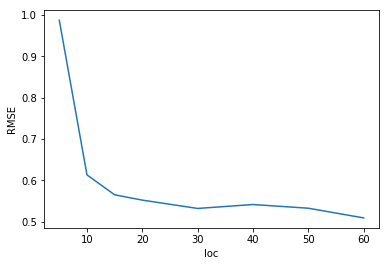

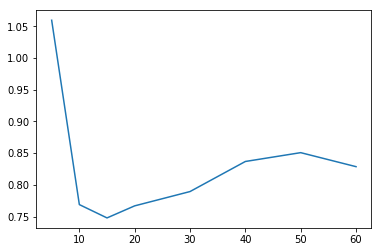

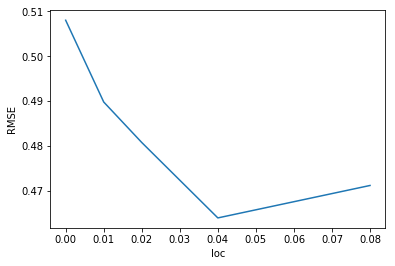

In [38]:
plt.figure()
plt.plot(loc_range, rmse_array_f[3, :])
plt.ylabel('RMSE')
plt.xlabel('loc')

plt.figure()
plt.plot(loc_range, rmse_array_f[3, :]
         /((1 + alpha_range[3]) * std_array_f[3, :]))

plt.figure()
plt.plot(alpha_range, rmse_array_a[:, 7])
plt.ylabel('RMSE')
plt.xlabel('loc')

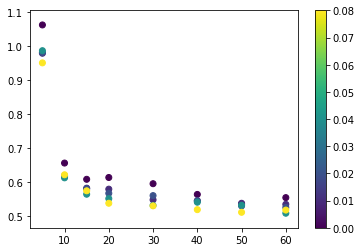

In [49]:
loc_array = np.repeat(loc_range[None, :], alpha_range.size, 0)
alpha_array = np.repeat(alpha_range[:, None], loc_range.size, -1)

plt.figure()
im = plt.scatter(
    loc_array.T,
    rmse_array_f.T,
    c=alpha_array.T)
plt.colorbar(im)

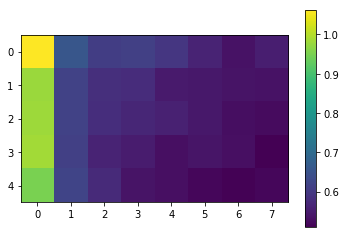

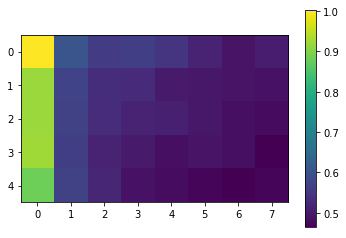

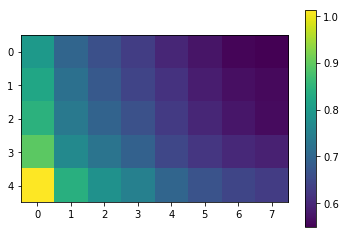

In [27]:
imshow(rmse_array_f)
imshow(rmse_array_a)

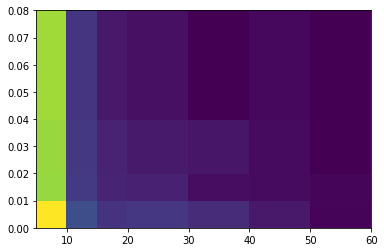

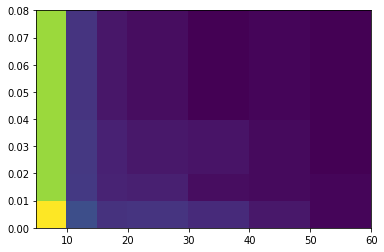

In [22]:
plt.figure()
plt.pcolormesh(loc_range,
               alpha_range,
               rmse_array_f)
plt.figure()
plt.pcolormesh(loc_range,
               alpha_range,
               rmse_array_a)

In [23]:
alpha_diff = np.diff(alpha_range)
alpha_plot = alpha_range - alpha_diff
# alpha_plot = np.concatenate(
#     [alpha_plot,
#      [alpha_range[-1] + alpha_diff[-1]]])

ValueError: operands could not be broadcast together with shapes (5,) (4,) 

In [18]:
alpha_diff

array([0.01, 0.01, 0.02, 0.04])

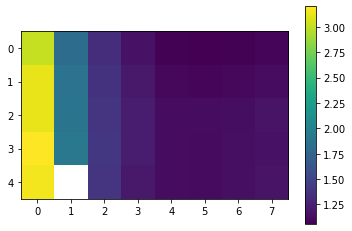

In [19]:
imshow(rmse_array_a)

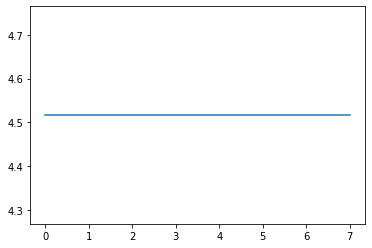

In [20]:
plt.figure()
plt.plot(rmse_array_f[0])

TypeError: Invalid shape (8,) for image data

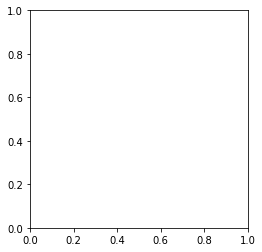

In [21]:
imshow(rmse_array_f[0])

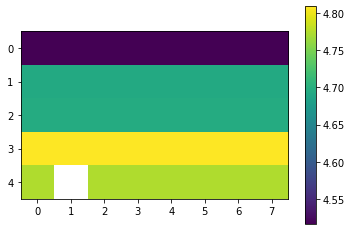

In [22]:
imshow(rmse_array_f)

In [25]:
mu_f[0].time

<xarray.DataArray 'time' (time: 1000)>
array([ 0.05,  0.1 ,  0.15, ..., 49.9 , 49.95, 50.  ])
Coordinates:
  * time     (time) float64 0.05 0.1 0.15 0.2 0.25 ... 49.85 49.9 49.95 50.0

In [21]:
this = mu_f[1]

In [ ]:
this = mu_f

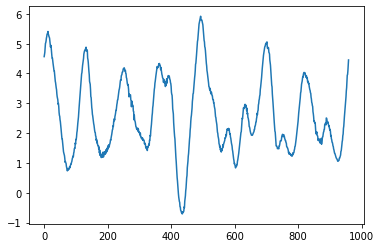

In [26]:
plt.figure()
plt.plot(this.isel(time=-1))